# DT503.4 Advanced Time Series Analysis: Traffic Accident Risk Prediction
*Last Updated: November 24, 2024*

## Overview
This notebook implements advanced time series analysis techniques to create a practical model for predicting traffic accident risks. We'll learn how to:

- Analyse temporal patterns in accident data
- Implement multiple forecasting approaches (SARIMA and Prophet)
- Create a production-ready prediction model
- Visualise results in PowerBI

### Prerequisites
Before starting this tutorial, ensure you have:
- Basic understanding of Python programming
- Familiarity with pandas and numpy
- PowerBI Desktop installed (for visualisation)

### Required Libraries

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from typing import Dict
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

## Data Loading and Preparation

First, let's define our TimeSeriesAnalyser class that will handle all our analysis:

In [ ]:
class TimeSeriesAnalyser:
    """Handles time series analysis of accident data."""
    
    def __init__(self):
        self.prophet_model = None
        self.sarima_model = None
        self.seasonal_patterns = {}
        self.weather_columns = None
        self.weather_means = None
    
    def analyse_seasonality(self, data: pd.DataFrame) -> Dict:
        """Analyse seasonal patterns in the data."""
        patterns = {
            'hourly': data.groupby('hour').size(),
            'daily': data.groupby('day_of_week').size(),
            'monthly': data.groupby('month').size()
        }
        
        self.seasonal_patterns = {
            'peak_hour': patterns['hourly'].idxmax(),
            'peak_day': patterns['daily'].idxmax(),
            'peak_month': patterns['monthly'].idxmax()
        }
        
        return self.seasonal_patterns

    def visualise_seasonality(self, data: pd.DataFrame):
        """Create visualisations of seasonal patterns."""
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
        
        # Hourly pattern
        hourly = data.groupby('hour').size()
        ax1.bar(hourly.index, hourly.values, color='skyblue')
        ax1.set_title('Hourly Distribution of Accidents')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Number of Accidents')
        ax1.grid(True, alpha=0.3)
        
        # Daily pattern
        daily = data.groupby('day_of_week').size()
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        ax2.bar(days, daily.values, color='lightgreen')
        ax2.set_title('Daily Distribution of Accidents')
        ax2.set_xlabel('Day of Week')
        ax2.set_ylabel('Number of Accidents')
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # Monthly pattern
        monthly = data.groupby('month').size()
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        ax3.bar(months, monthly.values, color='salmon')
        ax3.set_title('Monthly Distribution of Accidents')
        ax3.set_xlabel('Month')
        ax3.set_ylabel('Number of Accidents')
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nSeasonal Pattern Summary:")
        print(f"Peak hour: {self.seasonal_patterns['peak_hour']:02d}:00")
        print(f"Peak day: {days[self.seasonal_patterns['peak_day']]}")
        print(f"Peak month: {months[self.seasonal_patterns['peak_month']-1]}")

    def fit_prophet(self, data: pd.DataFrame):
        """Implement Prophet model for accident prediction."""
        # Prepare data for Prophet
        prophet_data = data.groupby('date').size().reset_index()
        prophet_data.columns = ['ds', 'y']
        
        # Add weather as a regressor with string column names
        weather_dummies = pd.get_dummies(data['weather_conditions'], prefix='weather')
        daily_weather = weather_dummies.groupby(data['date']).mean()
        prophet_data = prophet_data.join(daily_weather, on='ds')
        
        # Store weather columns for prediction
        self.weather_columns = daily_weather.columns
        self.weather_means = daily_weather.mean()
        
        # Initialise Prophet model
        self.prophet_model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            seasonality_mode='multiplicative'
        )
        
        # Add weather regressors
        for column in self.weather_columns:
            self.prophet_model.add_regressor(str(column))
            
        # Fit the model
        self.prophet_model.fit(prophet_data)
    
    def fit_sarima(self, data: pd.DataFrame):
        """Implement SARIMA model following course methodology."""
        # Prepare daily counts
        daily_counts = data.groupby('date').size()
        
        # SARIMA model with parameters from course
        self.sarima_model = SARIMAX(
            daily_counts,
            order=(2, 1, 1),
            seasonal_order=(1, 1, 1, 12)
        )
        
        # Fit the model
        self.sarima_results = self.sarima_model.fit()
    
    def predict_prophet(self, dates):
        """Make Prophet predictions including weather regressors."""
        future = pd.DataFrame({'ds': dates})
        
        # Add weather regressors with mean values
        for column in self.weather_columns:
            future[column] = self.weather_means[column]
            
        return self.prophet_model.predict(future)

## Data Loading and Validation

Let's create a function to load and validate our data, ensuring proper formatting:

In [ ]:
def load_and_validate_data(filepath: str) -> pd.DataFrame:
    """Load and validate accident data.
    
    Args:
        filepath: Path to accident data CSV
        
    Returns:
        Validated DataFrame with proper datetime handling
    """
    try:
        # Load the data
        data = pd.read_csv('dft-road-casualty-statistics-collision-2023_Devon_and_Cornwall.csv')
        
        # Validate required columns
        required_cols = [
            'date', 'time', 'latitude', 'longitude',
            'weather_conditions', 'road_type'
        ]
        
        if not all(col in data.columns for col in required_cols):
            raise ValueError(f"Missing required columns: {required_cols}")
        
        # Convert dates and add temporal features
        data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
        data['hour'] = pd.to_datetime(data['time'], format='%H:%M').dt.hour
        data['month'] = data['date'].dt.month
        data['day_of_week'] = data['date'].dt.dayofweek
        data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
        
        # Print data quality report
        print("Data Quality Report:")
        print(f"Date range: {data['date'].min()} to {data['date'].max()}")
        print(f"Total records: {len(data)}")
        print(f"Missing values: {data.isnull().sum().sum()}")
        
        return data
        
    except Exception as e:
        raise Exception(f"Error processing data: {str(e)}")

Now let's load our data and begin the analysis:

Data Quality Report:
Date range: 2023-01-02 00:00:00 to 2023-12-31 00:00:00
Total records: 2806
Missing values: 0


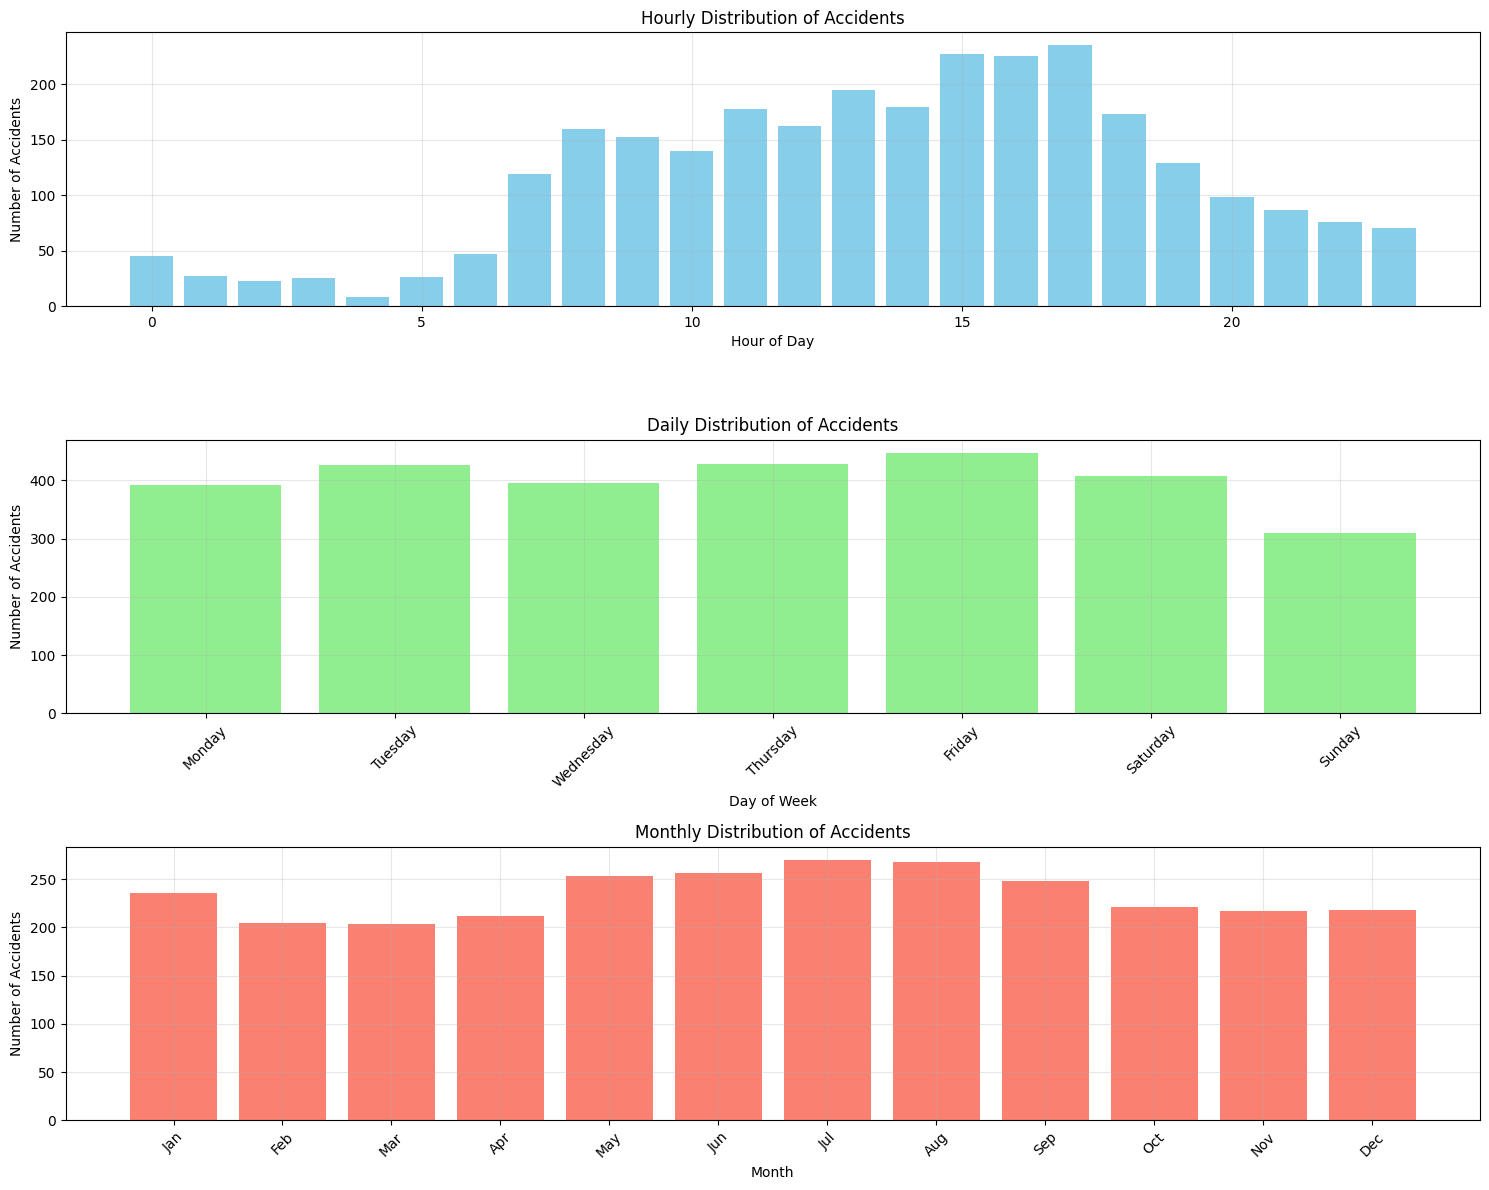

19:38:22 - cmdstanpy - INFO - Chain [1] start processing



Seasonal Pattern Summary:
Peak hour: 17:00
Peak day: Friday
Peak month: Jul
Training models...


19:38:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\garet\Documents\GitHub\DT503\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\garet\Documents\GitHub\DT503\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\garet\Documents\GitHub\DT503\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training complete!


In [ ]:
# Load the accident data
data = load_and_validate_data('accident_data.csv')

# Initialise analyser
analyser = TimeSeriesAnalyser()

# Analyse and visualise seasonal patterns
patterns = analyser.analyse_seasonality(data)
analyser.visualise_seasonality(data)

# Train models
print("Training models...")
analyser.fit_prophet(data)
analyser.fit_sarima(data)
print("Training complete!")

## Model Predictions

Let's generate and compare predictions from both models:

c:\Users\garet\Documents\GitHub\DT503\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\garet\Documents\GitHub\DT503\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


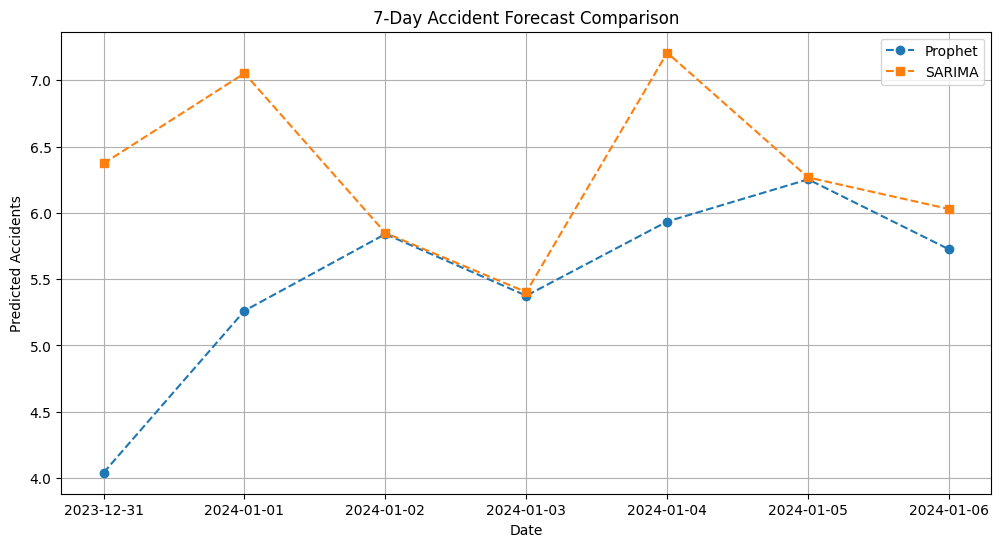


Daily Forecasts:
2023-12-31: Prophet=4.0, SARIMA=6.4
2024-01-01: Prophet=5.3, SARIMA=7.1
2024-01-02: Prophet=5.8, SARIMA=5.8
2024-01-03: Prophet=5.4, SARIMA=5.4
2024-01-04: Prophet=5.9, SARIMA=7.2
2024-01-05: Prophet=6.3, SARIMA=6.3
2024-01-06: Prophet=5.7, SARIMA=6.0


In [ ]:
# Generate future dates
future_dates = pd.date_range(
    start=data['date'].max(),
    periods=7,
    freq='D'
)

# Get predictions
prophet_forecast = analyser.predict_prophet(future_dates)
sarima_forecast = analyser.sarima_results.forecast(7)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(future_dates, prophet_forecast['yhat'], 
         label='Prophet', linestyle='--', marker='o')
plt.plot(future_dates, sarima_forecast, 
         label='SARIMA', linestyle='--', marker='s')
plt.title('7-Day Accident Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Predicted Accidents')
plt.legend()
plt.grid(True)
plt.show()

# Print forecast comparison
print("\nDaily Forecasts:")
for date, p_pred, s_pred in zip(future_dates, 
                               prophet_forecast['yhat'], 
                               sarima_forecast):
    print(f"{date.date()}: Prophet={p_pred:.1f}, SARIMA={s_pred:.1f}")

## Model Evaluation

Let's evaluate our models' performance using historical data:

In [ ]:
def evaluate_models(analyser: TimeSeriesAnalyser, 
                   test_data: pd.DataFrame) -> Dict:
    """Evaluate model performance using test data."""
    # Prepare actual values and ensure dates are sorted
    daily_actuals = test_data.groupby('date').size().sort_index()
    test_dates = daily_actuals.index
    
    print(f"Evaluation period: {test_dates.min()} to {test_dates.max()}")
    print(f"Number of test days: {len(test_dates)}")
    
    try:
        # Get Prophet predictions
        prophet_df = analyser.predict_prophet(test_dates)
        prophet_preds = pd.Series(
            prophet_df['yhat'].values,
            index=test_dates,
            name='Prophet'
        )
        
        # Get SARIMA predictions - adjust prediction length
        sarima_preds = analyser.sarima_results.predict(
            start=test_dates[0],
            end=test_dates[-1],
            dynamic=False  # Changed to False to match dates exactly
        )
        
        # Ensure predictions match actual dates exactly
        sarima_preds = sarima_preds[test_dates]
        
        # Convert to Series with matching index
        sarima_preds = pd.Series(
            sarima_preds,
            index=test_dates,
            name='SARIMA'
        )
        
        # Calculate ensemble predictions
        ensemble_preds = pd.Series(
            (prophet_preds + sarima_preds) / 2,
            index=test_dates,
            name='Ensemble'
        )
        
        # Verify alignments
        print(f"\nPrediction lengths:")
        print(f"Actuals: {len(daily_actuals)}")
        print(f"Prophet: {len(prophet_preds)}")
        print(f"SARIMA: {len(sarima_preds)}")
        print(f"Ensemble: {len(ensemble_preds)}")
        
        # Verify all indices match
        assert all(len(x) == len(daily_actuals) for x in [prophet_preds, sarima_preds, ensemble_preds])
        assert all(x.index.equals(daily_actuals.index) for x in [prophet_preds, sarima_preds, ensemble_preds])
        
        # Calculate metrics
        metrics = {
            'Prophet': {
                'RMSE': np.sqrt(mean_squared_error(daily_actuals, prophet_preds)),
                'MAE': mean_absolute_error(daily_actuals, prophet_preds)
            },
            'SARIMA': {
                'RMSE': np.sqrt(mean_squared_error(daily_actuals, sarima_preds)),
                'MAE': mean_absolute_error(daily_actuals, sarima_preds)
            },
            'Ensemble': {
                'RMSE': np.sqrt(mean_squared_error(daily_actuals, ensemble_preds)),
                'MAE': mean_absolute_error(daily_actuals, ensemble_preds)
            }
        }
        
        return metrics, daily_actuals, prophet_preds, sarima_preds, ensemble_preds
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        print(f"Test dates shape: {test_dates.shape}")
        print(f"SARIMA predictions shape: {sarima_preds.shape if 'sarima_preds' in locals() else 'Not created'}")
        raise

# Split data for evaluation
cutoff_date = '2023-12-01'
train_mask = data['date'] < cutoff_date
train_data = data[train_mask].copy()
test_data = data[~train_mask].copy()

print(f"Training period: {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Testing period: {test_data['date'].min()} to {test_data['date'].max()}")

# Train models on training data
print("\nTraining models...")
evaluation_analyser = TimeSeriesAnalyser()
evaluation_analyser.fit_prophet(train_data)
evaluation_analyser.fit_sarima(train_data)
print("Training complete!")

# Evaluate models
metrics, actuals, prophet_preds, sarima_preds, ensemble_preds = evaluate_models(
    evaluation_analyser, test_data
)

# Print metrics
print("\nModel Performance Metrics:")
print("\nRoot Mean Square Error (RMSE):")
for model, metrics_dict in metrics.items():
    print(f"{model}: {metrics_dict['RMSE']:.2f}")

print("\nMean Absolute Error (MAE):")
for model, metrics_dict in metrics.items():
    print(f"{model}: {metrics_dict['MAE']:.2f}")

Training period: 2023-01-02 00:00:00 to 2023-11-30 00:00:00
Testing period: 2023-12-01 00:00:00 to 2023-12-31 00:00:00

Training models...


19:38:24 - cmdstanpy - INFO - Chain [1] start processing
19:38:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\garet\Documents\GitHub\DT503\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\garet\Documents\GitHub\DT503\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\garet\Documents\GitHub\DT503\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training complete!
Evaluation period: 2023-12-01 00:00:00 to 2023-12-31 00:00:00
Number of test days: 30

Prediction lengths:
Actuals: 30
Prophet: 30
SARIMA: 30
Ensemble: 30

Model Performance Metrics:

Root Mean Square Error (RMSE):
Prophet: 4.76
SARIMA: 3.57
Ensemble: 4.01

Mean Absolute Error (MAE):
Prophet: 3.71
SARIMA: 2.73
Ensemble: 3.06


Let's visualise the evaluation results:

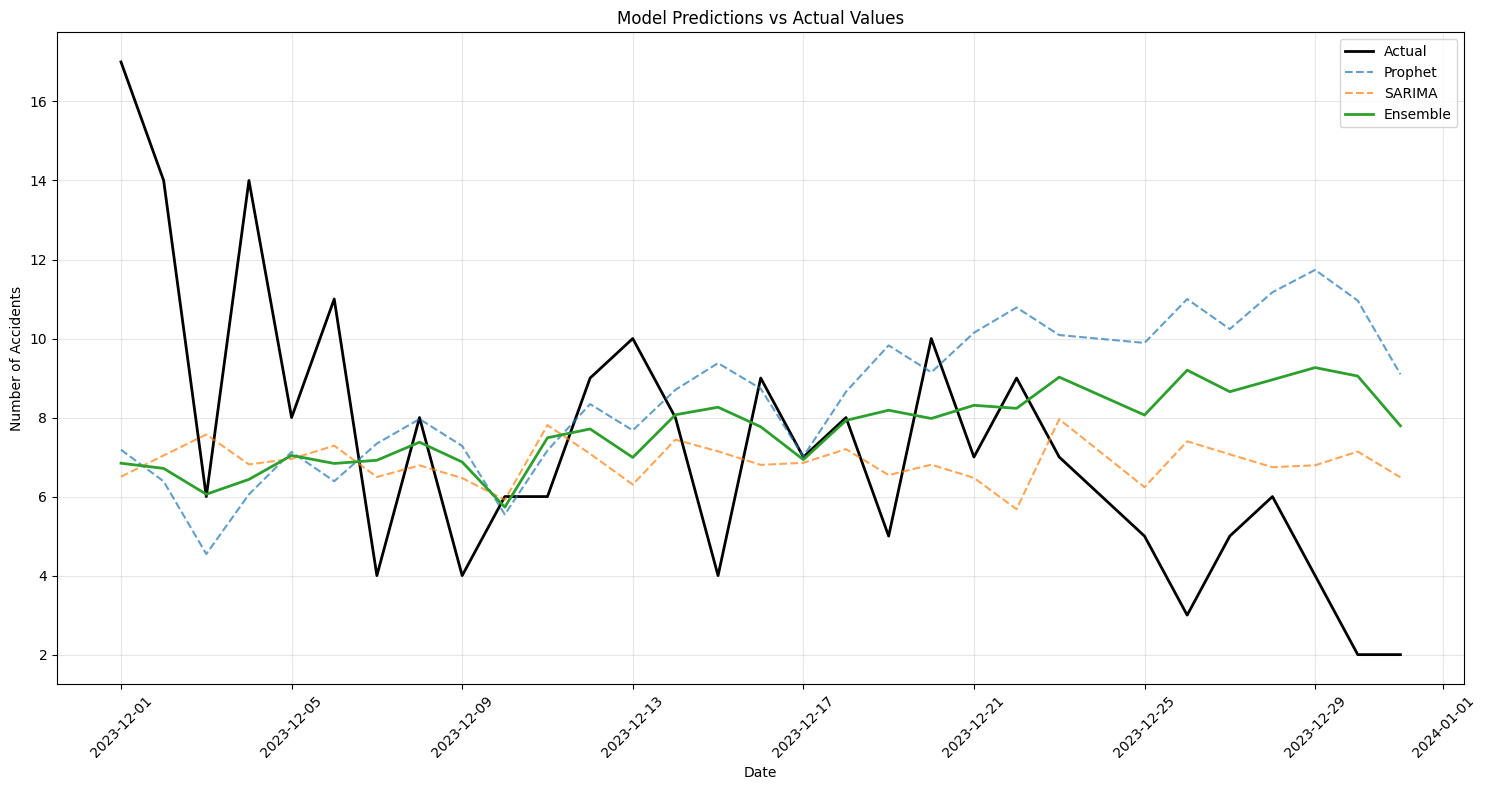

In [ ]:
# Create visualization
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(actuals.index, actuals, 
         label='Actual', color='black', linewidth=2)

# Plot predictions
plt.plot(actuals.index, prophet_preds, 
         label='Prophet', linestyle='--', alpha=0.7)
plt.plot(actuals.index, sarima_preds, 
         label='SARIMA', linestyle='--', alpha=0.7)
plt.plot(actuals.index, ensemble_preds, 
         label='Ensemble', linewidth=2)

plt.title('Model Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()